# Notebook 3: Data Mining Techniques
### DSA 2040A Group Project - Lung Cancer Data Analysis
### Team Members: Calvin, Tanveer, Samantha, Patricia, Susan and Arlen

#### Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


from sklearn.pipeline import Pipeline

# Scikit-learn for data mining
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
)
# Set plot style
sns.set_style("whitegrid")
# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# For saving/loading models
import joblib


# Section 1: Load Cleaned Data

In [15]:
CLEANED_DATA = '../data/transformed.csv' 
MODEL_SAVE_PATH = '../models/survival_predictor.pkl' 


df = pd.read_csv(CLEANED_DATA)
print(f"Cleaned data loaded successfully from {CLEANED_DATA}")

# Convert relevant columns to their appropriate types after loading from CSV
if 'diagnosis_date' in df.columns:
    df['diagnosis_date'] = pd.to_datetime(df['diagnosis_date'], errors='coerce')
if 'end_treatment_date' in df.columns:
    df['end_treatment_date'] = pd.to_datetime(df['end_treatment_date'], errors='coerce')

# Convert string object columns to 'category' dtype for better memory usage and explicit handling
categorical_cols_to_convert = ['gender', 'country', 'cancer_stage', 'smoking_status',
                                'treatment_type', 'age_group', 'bmi_category', 'cholesterol_category']
for col in categorical_cols_to_convert:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype('category')
# convert to 1 and 0(pseudo one hot encoding)
if 'family_history' in df.columns and df['family_history'].dtype == 'object':
        df['family_history'] = df['family_history'].map({'Yes': 1, 'No': 0}).astype(int)
if 'survived' in df.columns and df['survived'].dtype != 'int64':
        df['survived'] = df['survived'].astype(int)

print("\nFirst 5 rows of cleaned data:")
print(df.head())
print("\nCleaned Data Info:")
df.info()


Cleaned data loaded successfully from ../data/transformed.csv

First 5 rows of cleaned data:
   gender      country diagnosis_date cancer_stage  family_history  \
0  Female  Netherlands     2023-04-20    Stage III               1   
1  Female      Hungary     2023-04-05    Stage III               1   
2    Male   Luxembourg     2023-11-29      Stage I               0   
3    Male        Italy     2023-01-02      Stage I               0   
4  Female   Luxembourg     2023-12-24     Stage IV               0   

   smoking_status treatment_type end_treatment_date  survived  \
0  Passive Smoker        Surgery         2024-06-17         1   
1   Former Smoker       Combined         2024-04-09         0   
2  Passive Smoker       Combined         2025-01-08         0   
3    Never Smoked      Radiation         2024-12-27         0   
4    Never Smoked        Surgery         2024-10-28         1   

   treatment_duration  comorbidities_count age_group bmi_category  \
0                 424     

## 2. Data preprocessing
- We are going to define target variabels and features
- Filter out redundant columns
- identify numerical and categorical features for preprocessing
- 

In [16]:
from sklearn.pipeline import Pipeline

# Define target variable and features
TARGET = 'survived'
# Drop 
columns_to_drop = [TARGET, 'diagnosis_date', 'end_treatment_date', 'index', 'comorbidity_count']
# Filter out columns that do not exist in the DataFrame
columns_to_drop_existing = [col for col in columns_to_drop if col in df.columns]

X = df.drop(columns=columns_to_drop_existing)
y = df[TARGET]

# Identify numerical and categorical features for preprocessing
numerical_features = ['treatment_duration', 'comorbidities_count']
# Filter numerical_features to ensure they exist in X
numerical_features = [f for f in numerical_features if f in X.columns]

# All original categorical columns that need one hot encoding
categorical_features = ['gender', 'country', 'cancer_stage', 'smoking_status',
                        'treatment_type', 'age_group', 'bmi_category', 'cholesterol_category']
# Filter categorical_features to ensure they exist in X
categorical_features = [f for f in categorical_features if f in X.columns]

print(f"\nFeatures selected for modeling: {X.columns.tolist()}")
print(f"Numerical Features for scaling: {numerical_features}")
print(f"Categorical Features for One-Hot Encoding: {categorical_features}")

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' 
)



Features selected for modeling: ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status', 'treatment_type', 'treatment_duration', 'comorbidities_count', 'age_group', 'bmi_category', 'cholesterol_category']
Numerical Features for scaling: ['treatment_duration', 'comorbidities_count']
Categorical Features for One-Hot Encoding: ['gender', 'country', 'cancer_stage', 'smoking_status', 'treatment_type', 'age_group', 'bmi_category', 'cholesterol_category']


## 3. Model Selection and Training

#### Experimenting with different models

#### Data Splitting


In [17]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures the same proportion of classes in train and test sets
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 100599 samples
Testing set size: 25150 samples


### Logistic Regression


--- Logistic Regression Evaluation ---
Accuracy: 0.7793
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
ROC-AUC: 0.5000

--- Confusion Matrix ---


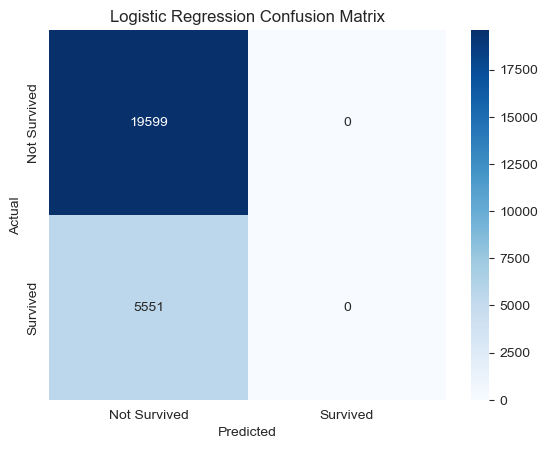


--- ROC Curve ---


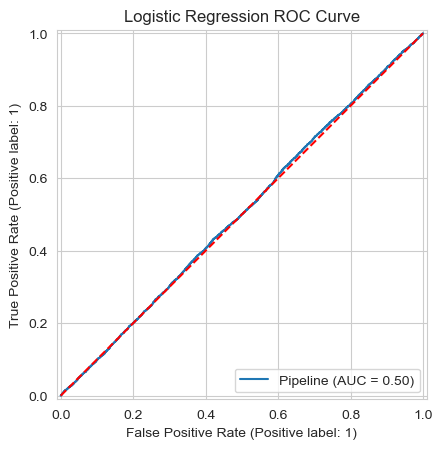

In [18]:
# Create the pipeline with preprocessor and classifier
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train the model
pipeline_lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = pipeline_lr.predict(X_test)

# --- Output and Visualization ---

# 1. Print Classification Metrics
print("--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_lr):.4f}\n")

# 2. Plot Confusion Matrix
print("--- Confusion Matrix ---")
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# 3. Plot ROC Curve
print("\n--- ROC Curve ---")
RocCurveDisplay.from_estimator(pipeline_lr, X_test, y_test)
plt.title('Logistic Regression ROC Curve')
plt.plot([0, 1], [0, 1], 'r--') # Dashed diagonal
plt.show()

#### Random Forest Classifier

In [ ]:
# Create the pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

# Train the model
pipeline_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = pipeline_rf.predict(X_test)

# --- Output and Visualization ---

# 1. Print Classification Metrics
print("--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_rf):.4f}\n")

# 2. Plot Confusion Matrix
print("--- Confusion Matrix ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# 3. Plot Feature Importances
print("\n--- Feature Importances ---")
# Get feature names after one-hot encoding
ohe_feature_names = pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Get importances
importances = pipeline_rf.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

KeyboardInterrupt: 

### Model Comparison

In [ ]:
print("--- Model Performance Comparison ---")
comparison_data = {
    "Model": ["Logistic Regression", "Random Forest"],
    "F1-Score": [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf)],
    "ROC-AUC": [roc_auc_score(y_test, y_pred_lr), roc_auc_score(y_test, y_pred_rf)]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)


### Saving the Best Model

In [ ]:
# Save the best model
joblib.dump({name of best model-----------}, '../models/survival_predictor.pkl')
print("Best model saved successfully!")